In [44]:
import math
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv("../data/processed/combined_profiles.csv")
df.head()

,age,location,ethnicity,occupation,status,description,scam,age_group,country
0,45,"New York, United states",white,engineering,divorced,"I’m balanced: secure enough to be vulnerable, ...",1,41-50,United states
1,22,"Debry, United Kingdom",mixed,self-employed,single,easygoing young girl looking for a nice partner,1,21-30,United Kingdom
2,49,"Providence, Utah, United States",white,military,divorced,I enjoy a variety of things. I am a 49 years o...,1,41-50,United States
3,48,"Castrop-Rauxel, Germany, or New York, or Los A...",white,finance,widowed,I am an optimistic person who has different in...,1,41-50,United States
4,48,"Miami, Florida, United States",white,other,widowed,"am a gentle woman, i love going to church, wil...",1,41-50,United States


# Predict with categorical features only

In [20]:
y = df['scam']
X = df.drop(columns=['scam', 'description', 'age', 'location'])

In [21]:
X

,ethnicity,occupation,status,age_group,country
0,white,engineering,divorced,41-50,United states
1,mixed,self-employed,single,21-30,United Kingdom
2,white,military,divorced,41-50,United States
3,white,finance,widowed,41-50,United States
4,white,other,widowed,41-50,United States
...,...,...,...,...,...
5970,white,military,single,61-70,United States
5971,mixed,construction,divorced,51-60,United States
5972,mixed,contractor,widowed,51-60,United Kingdom
5973,black,security,single,31-40,South Africa


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X_train)

OneHotEncoder(handle_unknown='ignore')

In [24]:
X_train_encoded = ohe.transform(X_train).toarray()
X_test_encoded = ohe.transform(X_test).toarray()

In [25]:
# fit a logistic regression model on X_train_encoded
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred = model.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       594
           1       0.97      0.96      0.96       601

    accuracy                           0.96      1195
   macro avg       0.96      0.96      0.96      1195
weighted avg       0.97      0.96      0.96      1195



In [27]:
y_pred_proba = model.predict_proba(X_test_encoded)
# calculate softmax for y_pred_proba
y_pred_proba_softmax = np.exp(y_pred_proba) / np.sum(np.exp(y_pred_proba), axis=1)[:, None]
# extract just the probability for class = 1
y_pred_proba_class_1 = y_pred_proba_softmax[:, 1]
y_pred_proba_class_1

array([0.26940718, 0.26906604, 0.26904928, ..., 0.7256274 , 0.26949777,
       0.29504752])

In [28]:
y_pred_log_proba = model.predict_log_proba(X_test_encoded)
y_pred_log_proba_softmax = np.exp(y_pred_log_proba) / np.sum(np.exp(y_pred_log_proba), axis=1)[:, None]
y_pred_log_proba_class_1 = y_pred_log_proba_softmax[:, 1]
y_pred_log_proba_class_1

array([1.18381732e-03, 3.16858381e-04, 2.74257935e-04, ...,
       9.86274802e-01, 1.41390560e-03, 6.45030040e-02])

## Check feature importance

In [29]:
# get the weights of the model
weights = model.coef_
weights = weights[0]

In [30]:
feature_importance = pd.DataFrame(zip(ohe.get_feature_names_out(), np.transpose(model.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:10]

,features,coef
237,country_United States,5.778728
235,country_United Kingdom,3.989595
59,status_widowed,2.993118
245,country_United states,2.607001
40,occupation_military,2.296445
132,country_Ghana,2.103191
61,age_group_21-30,2.021546
211,country_Switzerland,1.833908
193,country_Russia,1.793899
79,country_Afghanistan,1.532019


In [31]:
feature_importance.sort_values(by='coef', ascending=True)[:10]

,features,coef
229,country_USA,-3.814964
107,country_Colombia,-3.220335
8,ethnicity_hispanic,-2.746336
170,country_México,-2.500166
250,country_Venezuela,-2.493120
122,country_España,-2.318460
118,country_Ecuador,-2.315278
227,country_UK,-2.282323
182,country_Perú,-2.185689
110,country_Cuba,-1.799170


In [32]:
stats = feature_importance["coef"].describe()
stats

count    277.000000
mean      -0.000025
std        0.965155
min       -3.814964
25%       -0.377871
50%        0.019035
75%        0.436513
max        5.778728
Name: coef, dtype: float64

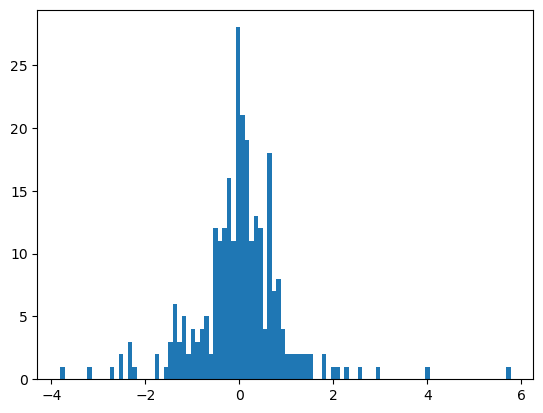

In [33]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

# Use descriptions to predict

In [34]:
X = df.loc[:, "description"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## BoW feature engineering

In [36]:
# perform BoW on the description
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [37]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       594
           1       0.86      0.84      0.85       601

    accuracy                           0.85      1195
   macro avg       0.85      0.85      0.85      1195
weighted avg       0.85      0.85      0.85      1195



In [38]:
vectorizer = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [39]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       594
           1       0.88      0.84      0.86       601

    accuracy                           0.86      1195
   macro avg       0.86      0.86      0.86      1195
weighted avg       0.86      0.86      0.86      1195



In [40]:
feature_importance = pd.DataFrame(zip(vectorizer.get_feature_names_out(), np.transpose(model.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:20]

,features,coef
22584,com,3.042688
26617,cool,2.195960
18194,caring,2.116556
105142,name,1.576759
152495,tell,1.523734
95406,man,1.330127
174173,yahoo,1.329244
139295,simple fun,1.249818
92218,lovely,1.176169
43883,fearing,1.105949


coefs represent the average change in the _log_ odds of the response variable associated with a one unit increase in the predictor variable. [see here](https://www.statology.org/interpret-logistic-regression-coefficients/)

In [41]:
stats = feature_importance["coef"].describe()
stats

count    175322.000000
mean          0.000761
std           0.052046
min          -1.073381
25%          -0.010348
50%           0.000046
75%           0.010727
max           3.042688
Name: coef, dtype: float64

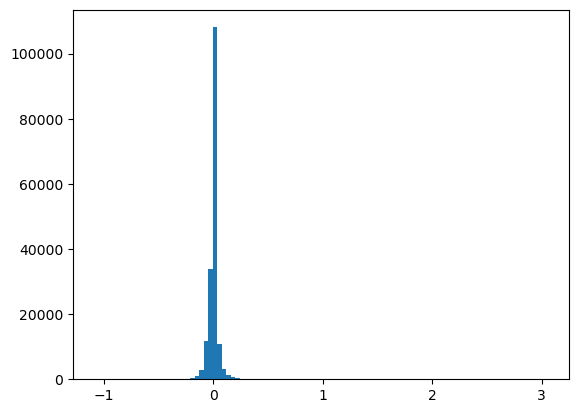

In [42]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

In [43]:
# get outliers using Tukey's method
iqr = stats["75%"] - stats["25%"]
k = 3
outliers = feature_importance[(feature_importance["coef"] < stats["25%"] - iqr * k) | (feature_importance["coef"] > stats["75%"] + iqr * k)]
outliers

,features,coef
17,10,-0.180511
26,10 languages,-0.136680
27,10 languages confident,-0.136680
43,100,-0.187553
50,100 family,-0.093544
...,...,...
175217,yr,-0.192148
175218,yr old,-0.192148
175220,yr old daughter,-0.095042
175223,yr old looking,0.077789


## Use TF-IDF

In [51]:
# perform tf-idf on the description
vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [52]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [53]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82       594
           1       0.78      0.93      0.85       601

    accuracy                           0.83      1195
   macro avg       0.85      0.83      0.83      1195
weighted avg       0.85      0.83      0.83      1195



# Use sentence embeddings

In [58]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
X_train.apply(lambda x: model.encode(x))

1881    [0.012104053, 0.03400637, 0.094185434, 0.10824...
2836    [-0.0023222486, -0.034438577, 0.044425547, 0.0...
4096    [0.019720212, -0.04182891, 0.042888325, 0.0232...
1173    [-0.022270039, -0.10763256, 0.13528822, 0.0692...
3358    [0.015009655, -0.03805801, 0.072911665, 0.0100...
                              ...                        
3772    [0.04209463, -0.11766362, 0.10115802, 0.117572...
5191    [-0.0050074295, -0.040384535, 0.048514873, -0....
5226    [-0.020864442, -0.076599546, 0.08812441, 0.067...
5390    [-0.03885498, -0.03188643, 0.037771672, -0.015...
860     [0.020760719, -0.11315738, 0.025631376, 0.0357...
Name: description, Length: 4780, dtype: object

In [61]:
# apply clustering to the embeddings
from sklearn.cluster import KMeans

In [62]:
X_train_encoded = X_train.apply(lambda x: model.encode(x))

ValueError: setting an array element with a sequence.

In [65]:
X_train_encoded = np.array(X_train_encoded.tolist())
X_train_encoded

array([[ 0.01210405,  0.03400637,  0.09418543, ..., -0.03186187,
        -0.11362939, -0.02503378],
       [-0.00232225, -0.03443858,  0.04442555, ...,  0.03976387,
         0.00305107, -0.03309342],
       [ 0.01972021, -0.04182891,  0.04288832, ...,  0.06683129,
        -0.05454608, -0.06358099],
       ...,
       [-0.02086444, -0.07659955,  0.08812441, ..., -0.01896485,
         0.0178203 , -0.03107213],
       [-0.03885498, -0.03188643,  0.03777167, ...,  0.04280732,
        -0.04428764, -0.0502914 ],
       [ 0.02076072, -0.11315738,  0.02563138, ..., -0.12051469,
         0.02833179, -0.04110634]])

In [79]:
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_train_encoded)
pca_2.explained_variance_ratio_

array([0.07327034, 0.05979137])

In [72]:
from sklearn.metrics import silhouette_score

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 2} Score 0.05035363358979088


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 3} Score 0.04200987935936376


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 4} Score 0.04405919319275712


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 5} Score 0.03236588173761434


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 10} Score 0.017620573687146902


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 15} Score 0.012764524187335272


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 20} Score 0.01144309957061879


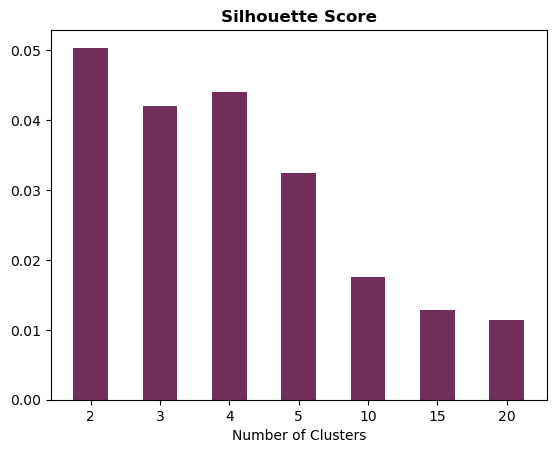

In [77]:
n_clusters = [2, 3, 4, 5, 10, 15, 20]
parameter_grid = [{"n_clusters": i} for i in n_clusters]

best_score = -1
kmeans_model = KMeans(n_clusters=2, random_state=42)     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X_train_encoded)          
    ss = silhouette_score(X_train_encoded, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        optimal_n_clusters = p["n_clusters"]
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(n_clusters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [78]:
kmeans = KMeans(n_clusters=optimal_n_clusters)
kmeans.fit(X_train_encoded)

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

In [84]:
pca_2_result.shape

(4780, 2)

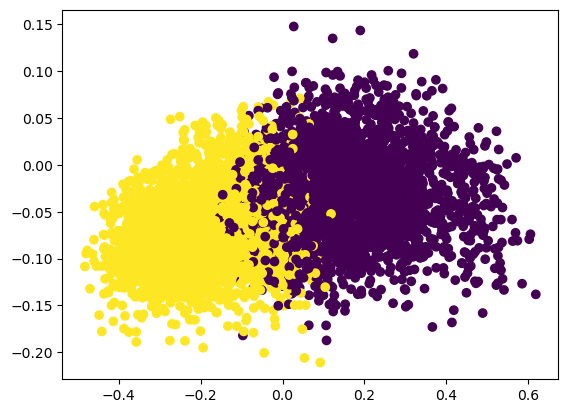

In [86]:
# plot the clusters
plt.scatter(pca_2_result[:, 0], X_train_encoded[:, 1], c=kmeans.labels_, cmap='viridis')
plt.show()